In this video, we'll explore different embedding models available in the Sentence Transformers ecosystem and understand their trade-offs.

Embedding models differ in many ways, including:
1. Size and computational requirements
2. Language support (monolingual vs. multilingual)
3. Context length limitations
4. Embedding dimensionality 
5. Performance on specific tasks

Sentence Transformers provides access to a wide range of pre-trained models optimized for different use cases. Some popular models include:

- all-MiniLM-L6-v2: A compact, efficient model that produces 384-dimensional embeddings
- all-mpnet-base-v2: A more powerful model with 768-dimensional embeddings
- paraphrase-multilingual-MiniLM-L12-v2: Supports 50+ languages
- multi-qa-mpnet-base-dot-v1: Optimized for question-answering tasks

When selecting an embedding model for your application, consider these factors:

1. Accuracy requirements: More powerful models typically produce better embeddings but require more computation
2. Inference speed: Smaller models are faster but may sacrifice some accuracy
3. Resource constraints: Model size affects memory usage and deployment options
4. Multilingual needs: Some models support multiple languages, while others are optimized for English
5. Specific tasks: Models fine-tuned for particular tasks often perform better on those tasks

Let's compare several embedding models to understand their trade-offs in a real-world production context.

                                Model  Dimensions  Size (MB)  Load Time (s)  Encoding Time (s)  Total Time (s)  Similar Pair Similarity  Different Pair Similarity  Contrast
                     all-MiniLM-L6-v2         384  86.644043       0.234772           0.033398        0.268673                 0.537720                   0.054547  0.483173
                    all-MiniLM-L12-v2         384 127.258301       1.664895           0.049076        1.714775                 0.600507                   0.175118  0.425388
                    all-mpnet-base-v2         768 417.657715       0.311670           0.144405        0.456845                 0.659811                   0.036776  0.623036
paraphrase-multilingual-MiniLM-L12-v2         384 448.813477       0.799739           0.045017        0.845507                 0.513916                   0.154445  0.359471


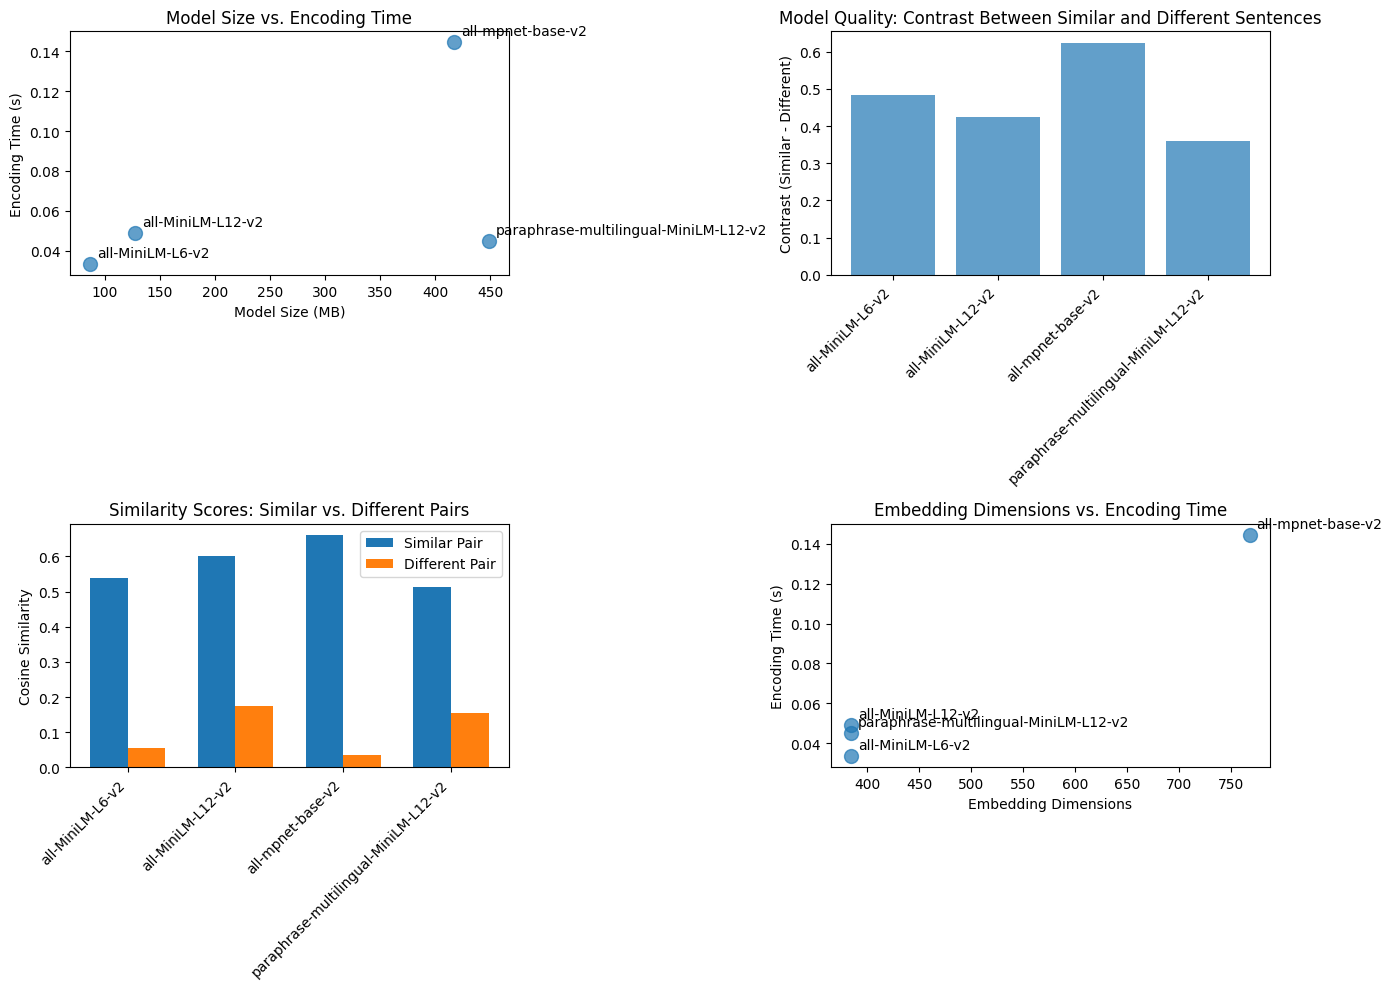

In [3]:
from sentence_transformers import SentenceTransformer, util
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define models to compare - ranging from small and fast to large and accurate
models = [
    'all-MiniLM-L6-v2',        # Small model (384d)
    'all-MiniLM-L12-v2',       # Medium model (384d)
    'all-mpnet-base-v2',       # Large model (768d)
    'paraphrase-multilingual-MiniLM-L12-v2'  # Multilingual model (384d)
]

# Example sentences for benchmarking
sentences = [
    "Machine learning models require significant computational resources.",
    "AI systems need a lot of computing power to train.",
    "The weather forecast predicts rain for tomorrow.",
    "I need to get a new computer for my office.",
    "What's the best algorithm for text classification?",
    "How can I optimize my neural network training time?"
]

# Create dataframe to store comparison results
results = []

for model_name in models:
    start_time = time.time()

    # Load model
    model_load_time = time.time()
    model = SentenceTransformer(model_name)
    model_load_time = time.time() - model_load_time

    # Encode sentences
    encoding_time = time.time()
    embeddings = model.encode(sentences)
    encoding_time = time.time() - encoding_time

    # Calculate embedding dimensionality
    dim = embeddings.shape[1]

    # Get model size (parameters)
    model_size_mb = sum(p.numel() for p in model.parameters()
                        ) * 4 / 1024 / 1024  # Approx size in MB

    # Calculate similarity between sentences 0 and 1 (semantically similar)
    sim_similar = util.cos_sim(embeddings[0:1], embeddings[1:2]).item()

    # Calculate similarity between sentences 0 and 2 (semantically different)
    sim_different = util.cos_sim(embeddings[0:1], embeddings[2:3]).item()

    # Contrast: difference between similar and different pairs
    contrast = sim_similar - sim_different

    total_time = time.time() - start_time

    # Store results
    results.append({
        'Model': model_name,
        'Dimensions': dim,
        'Size (MB)': model_size_mb,
        'Load Time (s)': model_load_time,
        'Encoding Time (s)': encoding_time,
        'Total Time (s)': total_time,
        'Similar Pair Similarity': sim_similar,
        'Different Pair Similarity': sim_different,
        'Contrast': contrast
    })

# Convert to DataFrame and display
df = pd.DataFrame(results)
print(df.to_string(index=False))

# Visualize model comparison
plt.figure(figsize=(14, 10))

# Plot 1: Model size vs. Encoding time
plt.subplot(2, 2, 1)
plt.scatter(df['Size (MB)'], df['Encoding Time (s)'], s=100, alpha=0.7)
for i, model in enumerate(df['Model']):
    plt.annotate(model, (df['Size (MB)'].iloc[i], df['Encoding Time (s)'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel('Model Size (MB)')
plt.ylabel('Encoding Time (s)')
plt.title('Model Size vs. Encoding Time')

# Plot 2: Model comparison - Contrast
plt.subplot(2, 2, 2)
bars = plt.bar(df['Model'], df['Contrast'], alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Contrast (Similar - Different)')
plt.title('Model Quality: Contrast Between Similar and Different Sentences')

# Plot 3: Similar vs. Different similarity scores
plt.subplot(2, 2, 3)
x = np.arange(len(df['Model']))
width = 0.35
plt.bar(x - width/2, df['Similar Pair Similarity'],
        width, label='Similar Pair')
plt.bar(x + width/2, df['Different Pair Similarity'],
        width, label='Different Pair')
plt.xticks(x, df['Model'], rotation=45, ha='right')
plt.ylabel('Cosine Similarity')
plt.title('Similarity Scores: Similar vs. Different Pairs')
plt.legend()

# Plot 4: Encoding time vs. number of dimensions
plt.subplot(2, 2, 4)
plt.scatter(df['Dimensions'], df['Encoding Time (s)'], s=100, alpha=0.7)
for i, model in enumerate(df['Model']):
    plt.annotate(model, (df['Dimensions'].iloc[i], df['Encoding Time (s)'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Encoding Time (s)')
plt.title('Embedding Dimensions vs. Encoding Time')

plt.tight_layout()
plt.show()

In [2]:
# Production considerations
print("\nProduction Deployment Considerations:")
print("1. Small models (like all-MiniLM-L6-v2) are suitable for high-throughput applications")
print("2. Larger models provide better semantic accuracy but require more resources")
print("3. Multilingual models add versatility but may sacrifice some performance for specific languages")
print("4. Consider batching and GPU acceleration for production deployments")
print("5. Dimension reduction techniques can be applied to large embeddings if storage is a concern")


Production Deployment Considerations:
1. Small models (like all-MiniLM-L6-v2) are suitable for high-throughput applications
2. Larger models provide better semantic accuracy but require more resources
3. Multilingual models add versatility but may sacrifice some performance for specific languages
4. Consider batching and GPU acceleration for production deployments
5. Dimension reduction techniques can be applied to large embeddings if storage is a concern
